In [187]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from tqdm import tqdm
import sys
import matplotlib as mpl

sys.modules.pop('generate_syn_data', None)
from generate_syn_data import *

sys.modules.pop('ARW_pow2', None)
from ARW_pow2 import *

sys.modules.pop('algo_syn', None)
from algo_syn import *


In [185]:
def simulate(seed, num_periods, true_means, variance, B_arr, B_arr_tr, fixed_windows, train_window, num_trials, alpha, delta, gamma, next_period):

    np.random.seed(seed)

    #B_arr is for val set
    B_arr_ends = np.cumsum(B_arr) - 1
    B_arr_tr_ends = np.cumsum(B_arr_tr) - 1

    err_dict = {}
    err_dict['ARW'] = {}
    for k in fixed_windows:
        err_dict[f'Val_{k}'] = {}
        for trial in range(num_trials):
            err_dict[f'Val_{k}'][trial] = []
            err_dict['ARW'][trial] = []

    seeds = np.arange(num_trials) + 2024

    for (trial, seed) in tqdm(enumerate(seeds)):
        
        np.random.seed(seed)

        X_val = generate_gaussian_sequence(B_arr = B_arr, true_means = true_means, variance=variance)
        X_tr = generate_gaussian_sequence(B_arr = B_arr_tr, true_means = true_means, variance=variance)

        for t in range(num_periods-1):
            
            idx_tr = B_arr_tr_ends[t]+1
            idx_val = B_arr_ends[t]+1

            mu_hat = train_synthetic(X_tr[:idx_tr], B_arr_tr[:t+1], train_window)[0]

            if next_period == True:
                mu_t = true_means[t+1]
            else: 
                mu_t = true_means[t]
            #calculate conformity score
            S_t = np.abs(X_val[:idx_val] - mu_hat)
            
            B_arr_t = B_arr[:t+1]

            khat, qt_khat, qtk_all = ARWQE(S_t, B_arr_t, alpha, delta, gamma)
            coverage_ARW = calculate_coverage(mu_hat, qt_khat, mu_t, variance)
            err_dict['ARW'][trial].append(np.mean(np.abs(coverage_ARW - 1+alpha)))
            
            #baseline: take quantile of fixed k
            for ik, k in enumerate(fixed_windows):
                log2k = int(np.log2(k))
                qtk = qtk_all[min(log2k, len(qtk_all)-1)]
                coverage_k = calculate_coverage(mu_hat, qtk, mu_t, variance)
                err_dict[f'Val_{k}'][trial].append(np.mean(np.abs(coverage_k - 1+alpha)))

    return err_dict

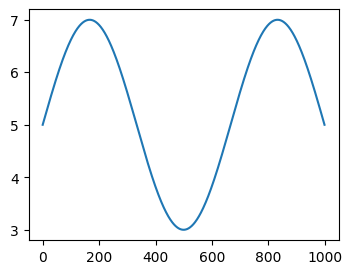

10it [00:12,  1.29s/it]

predicting for next period: False
['ARW', 'Val_1', 'Val_4', 'Val_16', 'Val_64', 'Val_256', 'Val_1024']
[0.03601234 0.18805163 0.07987634 0.03896241 0.04379914 0.06070439
 0.07587703]


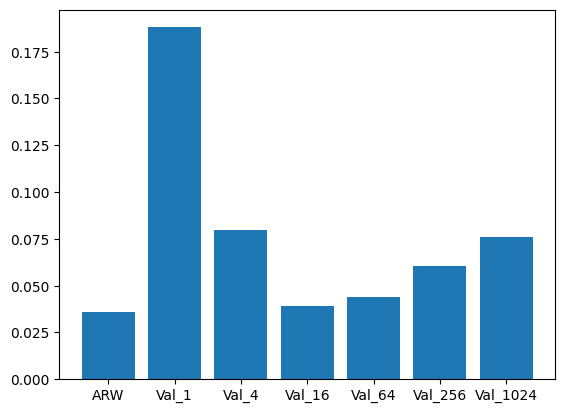

In [191]:
num_periods = 1000
seed = 6
np.random.seed(seed)
B_arr = np.random.randint(low=2, high=5, size=num_periods)
fixed_windows = [1, 4, 16, 64, 256, 1024]
train_window = [100]
num_trials = 10
variance = 1
alpha, delta, gamma = 0.1, 0.1, 1

#NOTE: change shift patterns
true_means = 2 * np.sin(np.linspace(0, 3 * np.pi, 1000)) + 5
#true_means = 5 * generate_true_means(num_periods-1, 2)
#true_means = 5 * np.ones(num_periods)

plt.figure(figsize=(4,3))
plt.plot(true_means)
plt.show()

#NOTE: change this to (not) predict for the next period instead
next_period = False

parameters = {
    "seed": seed,
    "num_periods": num_periods,
    "true_means": true_means,
    "B_arr": B_arr,
    "B_arr_tr": 3 * B_arr,  # This will be calculated based on B_arr
    "fixed_windows": fixed_windows,
    "train_window": train_window,
    "num_trials": num_trials,
    "variance": variance, 
    "next_period": next_period,
    "alpha": alpha, "delta": delta, "gamma": gamma,
}

err_dict = simulate(**parameters)

#process results in err_dict

methods = ['ARW'] + [f'Val_{k}' for k in fixed_windows]
print('predicting for next period:', next_period)
print(methods)
num_methods = len(methods)
err_array = np.zeros((len(methods), num_trials, num_periods-1))
for (i, key) in enumerate(err_dict.keys()):
    for (trial, trial_coverage) in err_dict[key].items():
        err_array[i, trial, :] = trial_coverage
#take average of coverage over time and trials for each method
mean_error = np.mean(np.mean(err_array[:, :, 100:], axis=2), axis=1)
std_error = np.std(np.mean(err_array[:, :, 100:], axis=2), axis=1)

#barplot errors
fig, ax = plt.subplots()
ax.bar(methods, mean_error)
print(mean_error)